# Model interpretation

In [64]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lime.lime_tabular import LimeTabularExplainer

In [65]:
MODELS = "../models/"
DATA = "../data/"
PROCESSED = DATA + "processed/"
RANDOM_STATE = 1

In [66]:
np.random.seed(RANDOM_STATE)


## Most predictive words of fake news.
We analyze the weights of the best __Logistic Regression__ to find which words are the most indicative of fake news and real news. According to the results obtained in the the `model_evaluation.ipynb` notebook, Logistic Regression with L2 penalty had slightly greater scores in all performance metrics so we use it for interpretation.

In [67]:
# Load the model
lr_l2 = joblib.load(MODELS + "lr_l2.pkl")

# Load the vectorizer object to map column indices back to their corresponding words
vectorizer = joblib.load(DATA + "vectorizer.pkl")

In [68]:
features = vectorizer.get_feature_names_out()
l2_weights = lr_l2.coef_[0]


In [69]:
# Sort the indexes of the weights by their corresponding weight value
idx_sorted = np.argsort(l2_weights)

# The largest weights will be at the end of the array
fake_news_idx = idx_sorted[-10:]
fake_news_words = [features[idx] for idx in fake_news_idx]
fake_news_weights = [l2_weights[idx] for idx in fake_news_idx]

# The smallest weights will be in the beggining of the array
real_news_idx = idx_sorted[:10]
real_news_words = [features[idx] for idx in real_news_idx]
real_news_weights = [l2_weights[idx] for idx in real_news_idx]

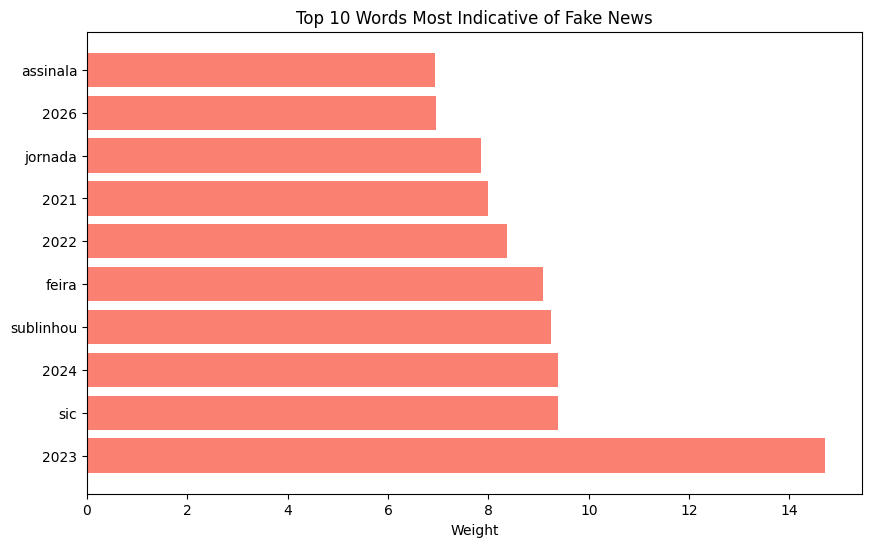

In [70]:
plt.figure(figsize=(10,6))
plt.barh(fake_news_words, fake_news_weights, color='salmon')
plt.xlabel('Weight')
plt.title('Top 10 Words Most Indicative of Fake News')
plt.gca().invert_yaxis() 
plt.show()

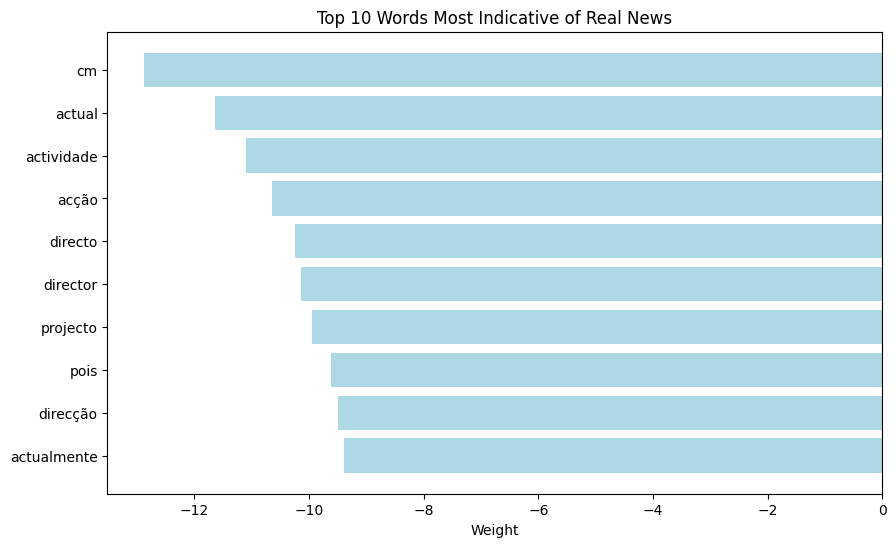

In [71]:
plt.figure(figsize=(10,6))
plt.barh(real_news_words, real_news_weights, color='lightblue')
plt.xlabel('Weight')
plt.title('Top 10 Words Most Indicative of Real News')
plt.gca().invert_yaxis() 
plt.show()

## Comparing number of non-zero weights in Logistic Regression with L1 and L2 penalty

In [72]:
# Load Logistic Regression with L1 penalty
lr_l1 = joblib.load(MODELS + "lr_l1.pkl")

In [73]:
threshold = 0.0001
l1_weights = lr_l1.coef_[0]

l1_non_zero_weights = len([w for w in l1_weights if abs(w) > threshold])
l2_non_zero_weights = len([w for w in l2_weights if abs(w) > threshold])

print("Number of non zero weights in Logistic Regression:")
print("\tL1 penalty: ", l1_non_zero_weights)
print("\tL2 penalty: ", l2_non_zero_weights)

Number of non zero weights in Logistic Regression:
	L1 penalty:  2019
	L2 penalty:  4999


## Explaining model classifications with specific observations


In [74]:
# Loading validation dataset
df_validation = pd.read_csv(PROCESSED + "validation_features.csv")
X_validation = df_validation.drop(columns=["Label"])
y_validation = df_validation["Label"]

In [75]:
idxs = [2921, 2437, 5557, 1697]

probabilities = [lr_l2.predict_proba(X_validation.loc[[idx]])[0] for idx in idxs]

/Users/guilhermejose/Repositories/NTT-DATA-challenge/env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


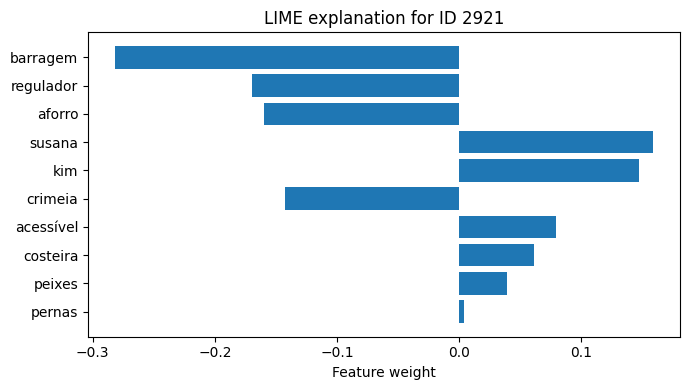

/Users/guilhermejose/Repositories/NTT-DATA-challenge/env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


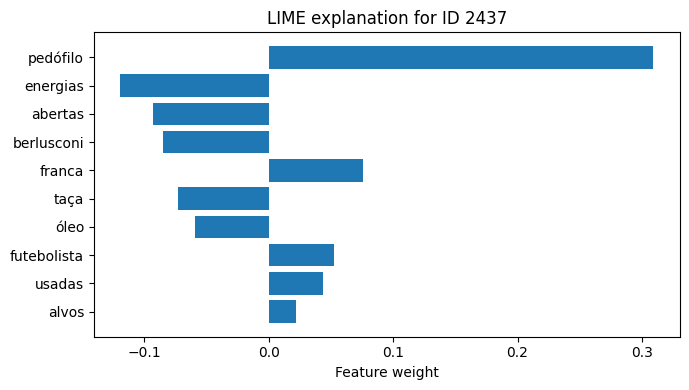

/Users/guilhermejose/Repositories/NTT-DATA-challenge/env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


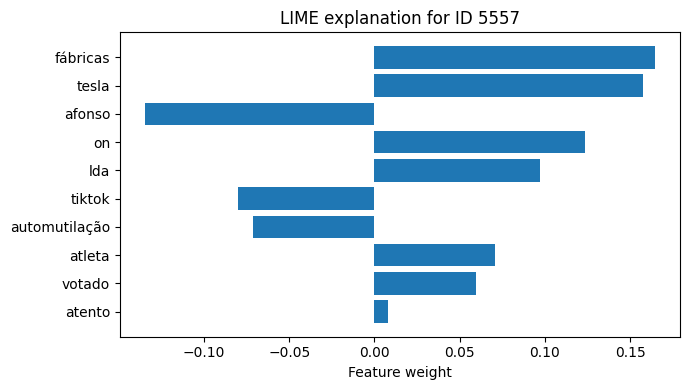

/Users/guilhermejose/Repositories/NTT-DATA-challenge/env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


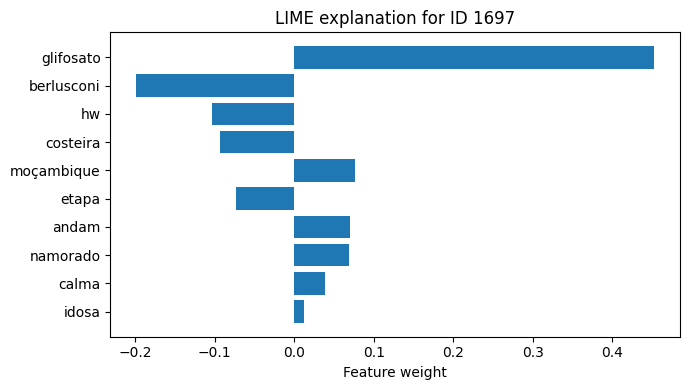

In [76]:
# 1. Create the explainer
explainer = LimeTabularExplainer(
    training_data=X_validation.values,              
    feature_names=X_validation.columns.tolist(),   
    class_names=[str(c) for c in lr_l2.classes_],  
    mode='classification',
    random_state=RANDOM_STATE
)

selected_ids = [2921, 2437, 5557, 1697]

for idx in selected_ids:
    row = X_validation.loc[[idx]]  # 2D

    # 2. Generate LIME explanation
    exp = explainer.explain_instance(
        data_row=row.values[0],
        predict_fn=lr_l2.predict_proba,
        num_features=10
    )
    
    # 3. Map numeric column indices to actual words
    exp_list = exp.as_list()
    readable_exp = []
    for feature, weight in exp_list:
        col_idx = int(feature.split()[0])
        word = features[col_idx] if col_idx < len(features) else feature
        readable_exp.append((word, weight))

    # 4. Plot with matplotlib
    words, weights = zip(*readable_exp)

    plt.figure(figsize=(7, 4))
    plt.barh(words, weights)
    plt.xlabel("Feature weight")
    plt.title(f"LIME explanation for ID {idx}")
    plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()

    
